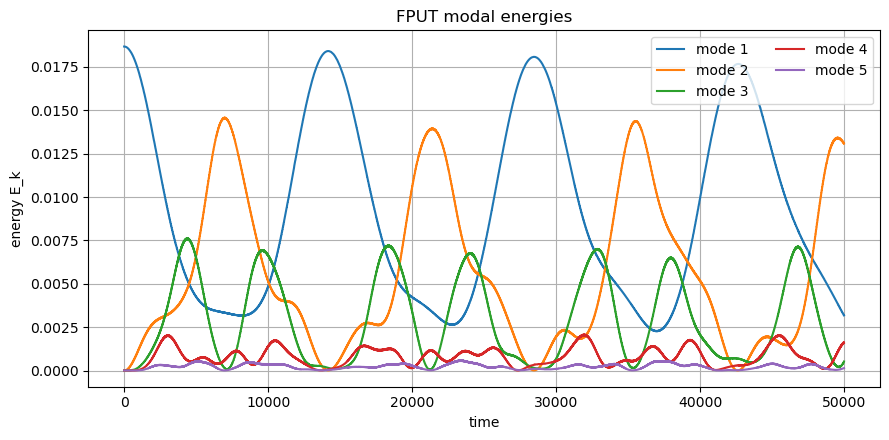

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

N = 32                    
mass = 1.0
k_lin = 1.0               
alpha = 0.25
beta = 0.08


dt = 0.1
tmax = 50000.0         
nsteps = int(np.round(tmax / dt))
save_every = 10           
n_save = nsteps // save_every + 1

A = 0.5                  
n = np.arange(1, N+1)
x = A * np.sin(np.pi * n / (N+1))   
v = np.zeros(N)                      

def compute_forces(x):
    x_ext = np.concatenate(([0.0], x, [0.0]))
    d = x_ext[1:] - x_ext[:-1]
    Fbond = d + alpha * (d**2) + beta * (d**3)   
    forces = Fbond[1:] - Fbond[:-1]   
    return forces

def project_modes(x, v, modes=5):
    norm = np.sqrt(2.0/(N+1))
    Q = np.zeros(modes)
    Qdot = np.zeros(modes)
    for k in range(1, modes+1):
        phi = np.sin(np.pi * k * (n) / (N+1))
        Qk = norm * np.dot(phi, x)
        Qdotk = norm * np.dot(phi, v)
        Q[k-1] = Qk
        Qdot[k-1] = Qdotk
    return Q, Qdot

def omega_k(k):
    return 2.0 * np.sin(np.pi * k / (2*(N+1)))

def total_energy(x, v):
    KE = 0.5 * mass * np.sum(v**2)
    x_ext = np.concatenate(([0.0], x, [0.0]))
    d = x_ext[1:] - x_ext[:-1]
    PE = 0.5 * np.sum(d**2) + (alpha/3.0) * np.sum(d**3) + (beta/4.0) * np.sum(d**4)
    return KE + PE

modes_to_track = 5
times = np.zeros(n_save)
E_modes_hist = np.zeros((n_save, modes_to_track))
total_energy_hist = np.zeros(n_save)
save_idx = 0

Q, Qdot = project_modes(x, v, modes=modes_to_track)

ctt = (alpha/3) * ((2/(N+1)) ** (3/2)) 
def get_delta_j(k, j):
    return np.sin(k*np.pi*(j+1)/(N+1)) - np.sin(k*np.pi*j/(N+1))
H3 = 0

for k in range(len(Q)):
    for l in range(len(Q)):
        for m in range(len(Q)): 
            spatial_sum = 0.0
            for j in range(N+1):
                spatial_sum += (get_delta_j(k, j, N) * 
                               get_delta_j(l, j, N) * 
                               get_delta_j(m, j, N))
            C_klm = ctt * spatial_sum
            
            H3 += C_klm * Q[k-1] * Q[l-1] * Q[m-1]




E_modes = 0.5 * (Qdot**2 + (np.array([omega_k(k) for k in range(1, modes_to_track+1)])**2) * Q**2)

times[save_idx] = 0.0
E_modes_hist[save_idx, :] = E_modes
total_energy_hist[save_idx] = total_energy(x, v)
save_idx += 1

forces = compute_forces(x)
for step in range(1, nsteps+1):
    v += 0.5 * (dt / mass) * forces
    x += dt * v
    forces = compute_forces(x)
    v += 0.5 * (dt / mass) * forces

    if (step % save_every) == 0 or step == nsteps:
        t = step * dt
        Q, Qdot = project_modes(x, v, modes=modes_to_track)
        E_modes = 0.5 * (Qdot**2 + (np.array([omega_k(k) for k in range(1, modes_to_track+1)])**2) * Q**2)
        times[save_idx] = t
        E_modes_hist[save_idx, :] = E_modes
        total_energy_hist[save_idx] = total_energy(x, v)
        save_idx += 1

times = times[:save_idx]
E_modes_hist = E_modes_hist[:save_idx, :]
total_energy_hist = total_energy_hist[:save_idx]

plt.figure(figsize=(9,4.5))
for m in range(modes_to_track):
    plt.plot(times, E_modes_hist[:, m], label=f'mode {m+1}')

plt.xlabel('time')
plt.ylabel('energy E_k')
plt.title('FPUT modal energies')
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()




